In [1]:
from disk_utils_jax import jax_model
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np
from interpolated_univariate_spline import InterpolatedUnivariateSpline

jax.config.update("jax_enable_x64", False)

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

## Creating Image Models

In [3]:

# DHG parameters
spf_params = {'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

# Initial spline guess
init_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
KNOTS = 10
x = np.cos(np.linspace(0, np.pi, KNOTS))
y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, x)

# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params = disk_params1, spf_params = y)
end = datetime.now()
time1 = end-start
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params2, spf_params = spf_params)
end = datetime.now()
print(end-start)

0:00:07.056496
0:00:03.871837


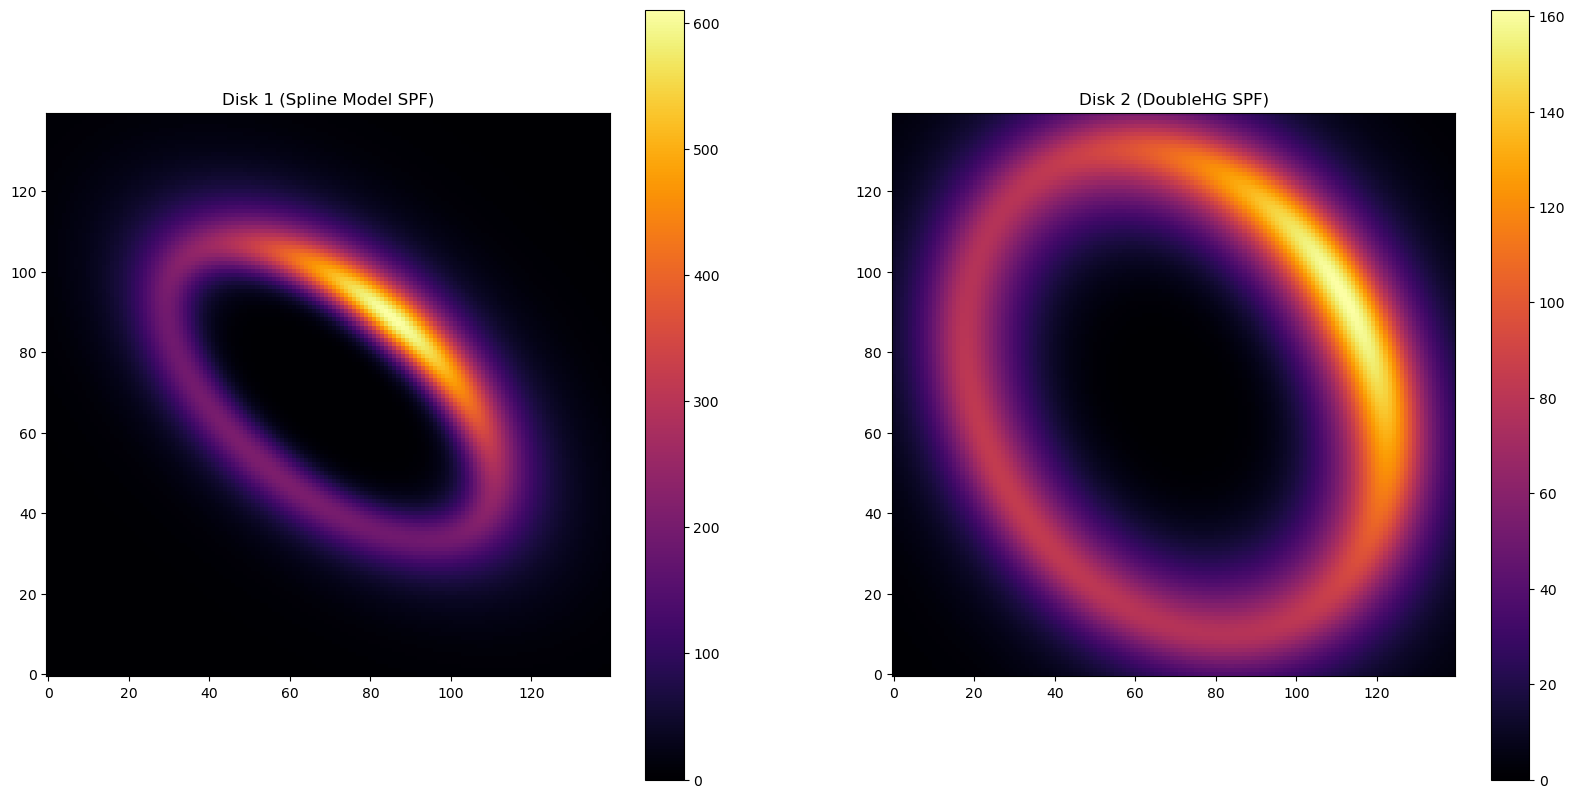

In [4]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Spline Model SPF)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (DoubleHG SPF)")
plt.colorbar(im,ax=axes[1])

### Testing Runtimes

In [5]:
def test_spline_function():
    jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params = disk_params1, spf_params = y)

def test_DHG_function():
    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params1, spf_params = spf_params)

In [6]:
%timeit test_spline_function()
%timeit test_DHG_function()

2.51 ms ± 404 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
140 µs ± 455 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Optimizing with Spline Models

In [7]:
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

# initial spline guess
init_spf_params = {'g1': 0.5, 'g2': -0.5, 'weight': 0.5}
init_spf = DoubleHenyeyGreenstein_SPF.init([init_spf_params['g1'], init_spf_params['g2'], init_spf_params['weight']])
KNOTS = 10
x = np.cos(np.linspace(0, np.pi, KNOTS))
params = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, x)

all_pars = jnp.concatenate((disk_params_1d_jax, params))

In [8]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

target_image = disk_image2+noise

In [9]:
from regression import log_likelihood_1d_pos_all_pars_func
from scipy.optimize import minimize

llp = lambda x: log_likelihood_1d_pos_all_pars_func(x, DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF,
                    disk_params2["flux_scaling"], target_image, jnp.ones(disk_image2.shape)*noise_level)

def convert_to_dict(disk_params, flux_scaling=1e6):
    disk_dict = {}
    disk_dict['inclination'] = disk_params[3]
    disk_dict['position_angle'] = disk_params[4]
    disk_dict['alpha_in'] = disk_params[0]
    disk_dict['alpha_out'] = disk_params[1]
    disk_dict['flux_scaling'] = flux_scaling
    disk_dict['sma'] = disk_params[2]
    return disk_dict

In [10]:
no_grad_method = "Nelder-Mead"
soln_nm = minimize(llp, all_pars, method=no_grad_method)
disk_fit_nm = convert_to_dict(soln_nm.x)

soln_go = minimize(llp, all_pars, method = None)
disk_fit_go = convert_to_dict(soln_go.x)

print(soln_go)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 90131.546875
        x: [ 3.156e+00 -1.079e+01 ...  1.801e-01  2.476e-01]
      nit: 25
      jac: [-2.867e+01  8.390e+00 ...  0.000e+00 -5.243e+05]
 hess_inv: [[ 4.556e+07  3.391e+08 ... -1.324e+04 -5.228e+03]
            [ 3.391e+08  2.524e+09 ... -9.853e+04 -3.892e+04]
            ...
            [-1.324e+04 -9.853e+04 ...  3.846e+00  1.519e+00]
            [-5.228e+03 -3.892e+04 ...  1.519e+00  1.000e+00]]
     nfev: 1556
     njev: 91


In [11]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm) + str(soln_nm.x[5:]))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_func(soln_nm.x, DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Gradient Optimization Disk Parameters: " + str(disk_fit_go) + str(soln_go.x[5:]))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_func(soln_go.x, DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 39.952995, 'position_angle': 29.989548, 'alpha_in': 4.8588986, 'alpha_out': -7.0349584, 'flux_scaling': 1000000.0, 'sma': 40.166515}[0.41612643 0.23500088 0.10948075 0.07781148 0.0554588  0.04725696
 0.04797288 0.05552272 0.1968913  0.41729844]
Log-Likelihood: 86325.13
Gradient Optimization Disk Parameters: {'inclination': 70.89768041662272, 'position_angle': 34.124953957414995, 'alpha_in': 3.156442464841138, 'alpha_out': -10.787980869838112, 'flux_scaling': 1000000.0, 'sma': 96.30296958613613}[0.24632191 0.18039912 0.05888902 0.05883441 0.00411861 0.04429109
 0.05738707 0.09761415 0.18006245 0.24757434]
Log-Likelihood: 90131.55
Actual Disk Parameters: {'inclination': 40.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}{'g1': 0.5, 'g2': -0.3, 'weight': 0.7}
Log-Likelihood: 86329.32


In [12]:
disk_fit_nm = convert_to_dict(soln_nm.x[0:5])
spf_params_nm = soln_nm.x[5:]

disk_fit_go = convert_to_dict(soln_go.x[0:5])
spf_params_go = soln_go.x[5:]

disk_image1_ap = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params=disk_params1, spf_params=params)

disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params=disk_fit_nm,
                               spf_params=spf_params_nm)
disk_image_fit_go = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params=disk_fit_go,
                               spf_params=spf_params_go)

Text(0.5, 1.0, 'Grad Optimized Disk')

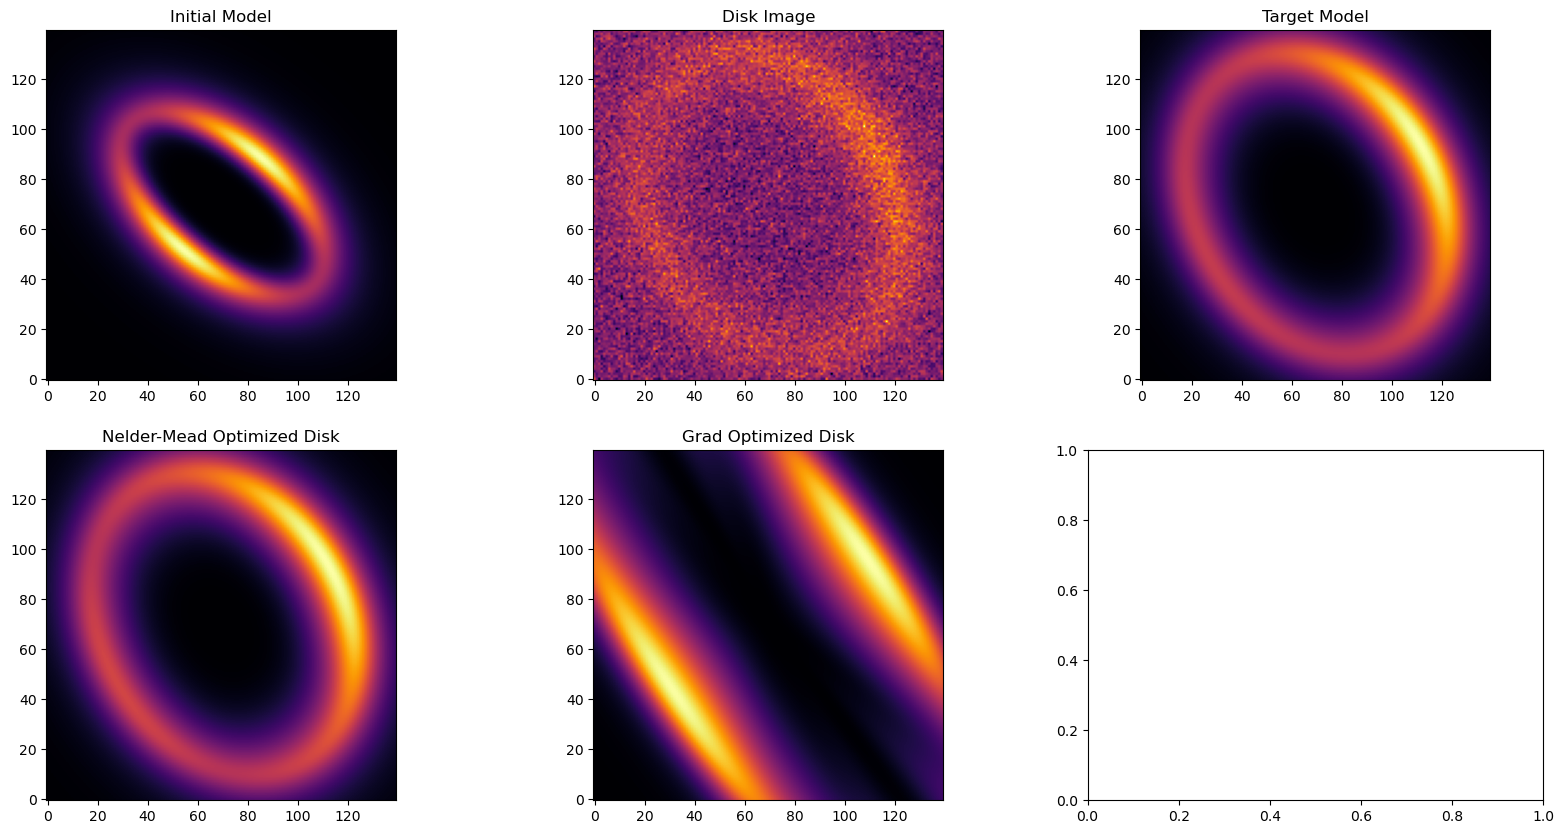

In [13]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

axes[0][0].imshow(disk_image1_ap, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[0][2].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0][2].set_title("Target Model")

axes[1][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[1][0].set_title("Nelder-Mead Optimized Disk")

axes[1][1].imshow(disk_image_fit_go, origin='lower', cmap='inferno')
axes[1][1].set_title("Grad Optimized Disk")

In [14]:
def nelder_mead_test():
    soln = minimize(llp, all_pars, method="Nelder-Mead")
    
def gradient_optimization_test():
    soln = minimize(llp, all_pars, method=None)

In [15]:
#%timeit nelder_mead_test()
#%timeit gradient_optimization_test()

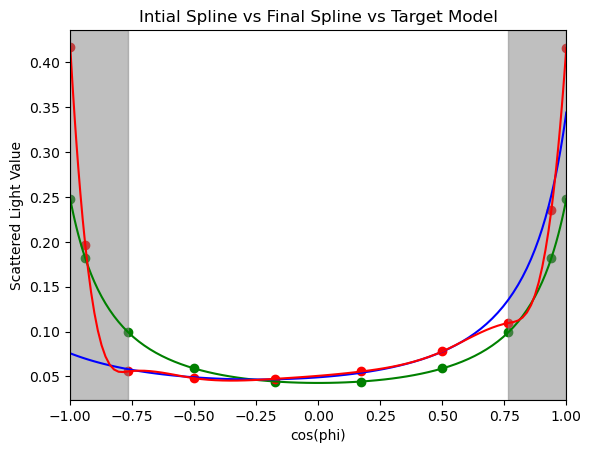

In [16]:
# DHG parameters
spf_params = {'g1': 0.5, 'g2': -0.3, 'weight': 0.7}


# Initial spline guess
init_spf_params = {'g1': 0.5, 'g2': -0.5, 'weight': 0.5}
init_spf = DoubleHenyeyGreenstein_SPF.init([init_spf_params['g1'], init_spf_params['g2'], init_spf_params['weight']])
KNOTS = 10
init_x = np.cos(np.linspace(0, np.pi, KNOTS))
init_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_x)
init_xs = np.cos(np.linspace(0, np.pi, 100))
init_ys = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_xs)

tar_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
tar_x = np.cos(np.linspace(0, np.pi, 100))
tar_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(tar_spf, tar_x)

# spf_params_nm
spline_model = InterpolatedSpline_SPF.init(spf_params_nm)
fin_x = np.cos(np.linspace(0, np.pi, KNOTS))
fin_y = spline_model(fin_x)
fin_xs = np.cos(np.linspace(0, np.pi, 100))
fin_ys = spline_model(fin_xs)

plt.scatter(init_x, init_y, color = 'g')
plt.plot(init_xs, init_ys, color = 'g')
plt.plot(tar_x, tar_y, color = 'b')
plt.scatter(fin_x, fin_y, color = 'r')
plt.plot(fin_xs, fin_ys, color = 'r')

# Use axvspan to create a vertical span from xmin to xmax
plt.axvspan(-1, np.cos((180-disk_params2['inclination'])*np.pi/180), color='grey', alpha=0.5)
plt.axvspan(np.cos(disk_params2['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
plt.xlim(-1, 1)

plt.xlabel("cos(phi)")
plt.ylabel("Scattered Light Value")
plt.title("Intial Spline vs Final Spline vs Target Model")
plt.show()